## Loading data

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
DATA_DIR = '/home/ruslan/Desktop/dataset/'

x_train_dir = os.path.join(DATA_DIR, 'images/train/')
y_train_dir = os.path.join(DATA_DIR, 'labels/train/')

x_valid_dir = os.path.join(DATA_DIR, 'images/val/')
y_valid_dir = os.path.join(DATA_DIR, 'labels/val/')

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [5]:
class MSegDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    MSEG_CLASSES = \
    ['backpack', 'umbrella', 'bag', 'tie', 'suitcase', 'case', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
     'bear', 'zebra', 'giraffe', 'animal_other', 'microwave', 'radiator', 'oven', 'toaster', 'storage_tank',
     'conveyor_belt', 'sink', 'refrigerator', 'washer_dryer', 'fan', 'dishwasher', 'toilet', 'bathtub', 'shower', 'tunnel',
     'bridge', 'pier_wharf', 'tent', 'building', 'ceiling', 'laptop', 'keyboard', 'mouse', 'remote', 'cell phone',
     'television', 'floor', 'stage', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot_dog',
     'pizza', 'donut', 'cake', 'fruit_other', 'food_other', 'chair_other', 'armchair', 'swivel_chair', 'stool',
     'seat', 'couch', 'trash_can', 'potted_plant', 'nightstand', 'bed', 'table', 'pool_table', 'barrel', 'desk',
     'ottoman', 'wardrobe', 'crib', 'basket', 'chest_of_drawers', 'bookshelf', 'counter_other', 'bathroom_counter',
     'kitchen_island', 'door', 'light_other', 'lamp', 'sconce', 'chandelier', 'mirror', 'whiteboard', 'shelf',
     'stairs', 'escalator', 'cabinet', 'fireplace', 'stove', 'arcade_machine', 'gravel', 'platform', 'playingfield',
     'railroad', 'road', 'snow', 'sidewalk_pavement', 'runway', 'terrain', 'book', 'box', 'clock', 'vase',
     'scissors', 'plaything_other', 'teddy_bear', 'hair_dryer', 'toothbrush', 'painting', 'poster', 'bulletin_board',
     'bottle', 'cup', 'wine_glass', 'knife', 'fork', 'spoon', 'bowl', 'tray', 'range_hood', 'plate', 'person',
     'rider_other', 'bicyclist', 'motorcyclist', 'paper', 'streetlight', 'road_barrier', 'mailbox', 'cctv_camera',
     'junction_box', 'traffic_sign', 'traffic_light', 'fire_hydrant', 'parking_meter', 'bench', 'bike_rack',
     'billboard', 'sky', 'pole', 'fence', 'railing_banister', 'guard_rail', 'mountain_hill', 'rock', 'frisbee',
     'skis', 'snowboard', 'sports_ball', 'kite', 'baseball_bat', 'baseball_glove', 'skateboard', 'surfboard',
     'tennis_racket', 'net', 'base', 'sculpture', 'column', 'fountain', 'awning', 'apparel', 'banner', 'flag','blanket',
     'curtain_other', 'shower_curtain', 'pillow', 'towel', 'rug_floormat', 'vegetation', 'bicycle', 'car',
     'autorickshaw', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'trailer', 'boat_ship', 'slow_wheeled_object',
     'river_lake', 'sea', 'water_other', 'swimming_pool', 'waterfall', 'wall', 'window', 'window_blind']
    
    # first 8 labels are reserved in Unity
    UNITY_CLASSES = \
    ['default', 'default', 'default', 'default', 'default', 'default', 'default', 'default',
     'person', 'rider_other', 'bicycle', 'building', 'sidewalk_pavement', 'road', 'wall', 'fence', 'pole',
     'traffic_light', 'traffic_sign', 'vegetation', 'terrain', 'potted_plant', 'lane_marking',
     'motorcycle', 'car', 'truck', 'bus', 'train', 'pedestrian_crossing', 'fire_hydrant', 'bench', 'void']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.get_y_fn = lambda x: f'{Path(x).stem[:-3]+"layer"}.png'
        
        self.ids = os.listdir(images_dir)
        self.mask_ids = [self.get_y_fn(iD) for iD in self.ids]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        
        # convert str names to class values on masks
        self.class_values = [self.UNITY_CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_1d = cv2.imread(self.masks_fps[i], 0)
        mask_mseg = self.mask2mseg(mask_1d)
        
        return image, mask_mseg
#         # extract certain classes from mask (e.g. cars)
#         masks = [(mask_1d == v) for v in self.class_values]
#         mask = np.stack(masks, axis=-1).astype('float')
        
#         # apply augmentations
#         if self.augmentation:
#             sample = self.augmentation(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
        
#         # apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
            
#         return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    def mask2mseg(self, mask_1d):
        VOID_LABEL = 194
        m = np.array(mask_1d)
        m[m<8] = VOID_LABEL # set labels reserved by Unity for default classes to void
        # do labels remmapings with mask[mask==old_label] = new_mseg_label
        for label in self.UNITY_CLASSES:
            if label in self.MSEG_CLASSES:
                m[m==self.UNITY_CLASSES.index(label)] = self.MSEG_CLASSES.index(label)
            m[m==self.UNITY_CLASSES.index('pedestrian_crossing')] = self.MSEG_CLASSES.index('road')
            m[m==self.UNITY_CLASSES.index('lane_marking')] = self.MSEG_CLASSES.index('road')
            m[m==self.UNITY_CLASSES.index('void')] = VOID_LABEL
        return m

building


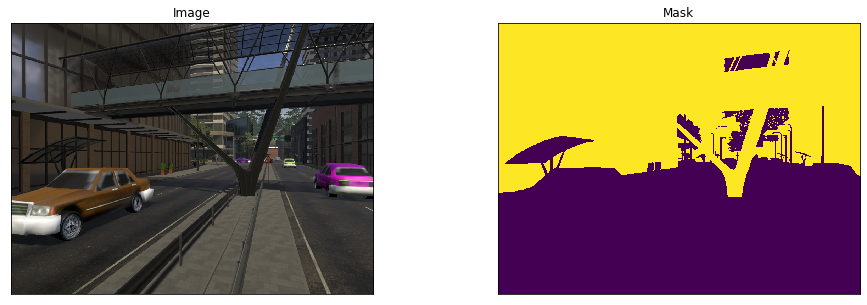

potted_plant


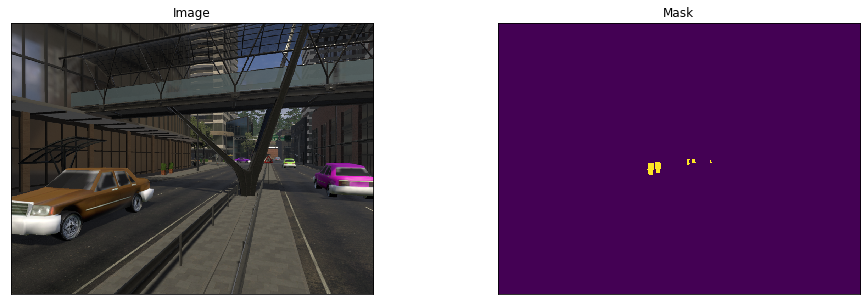

road


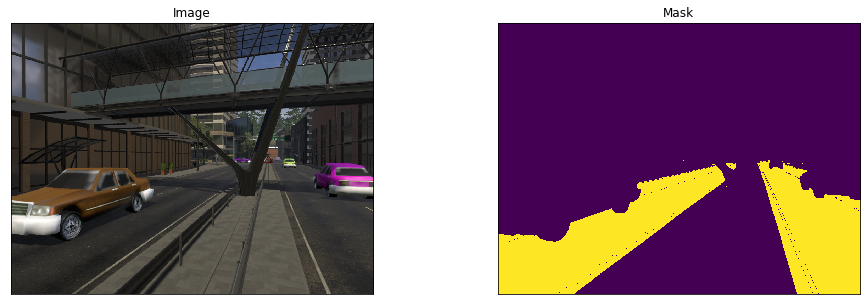

sidewalk_pavement


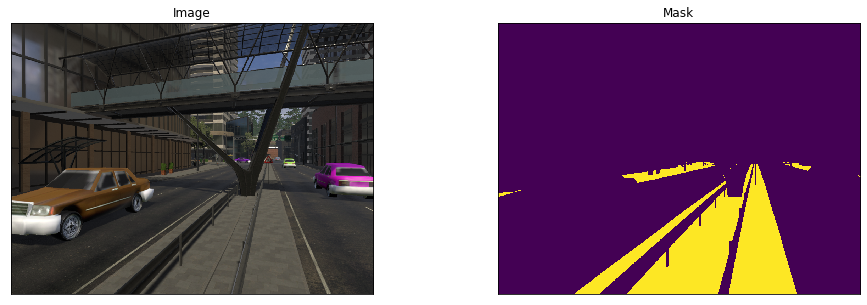

terrain


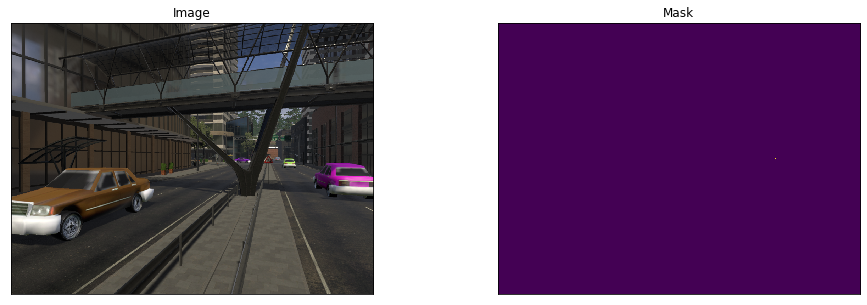

rider_other


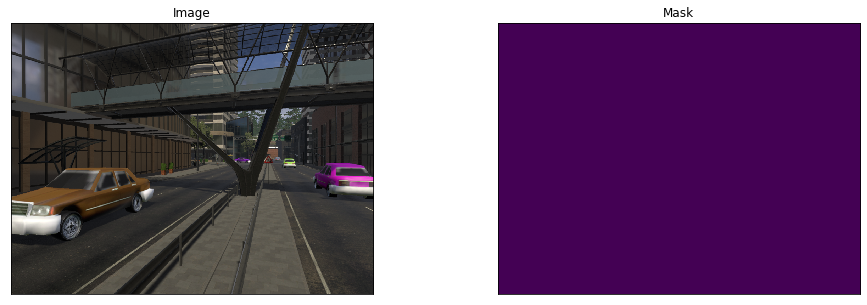

traffic_sign


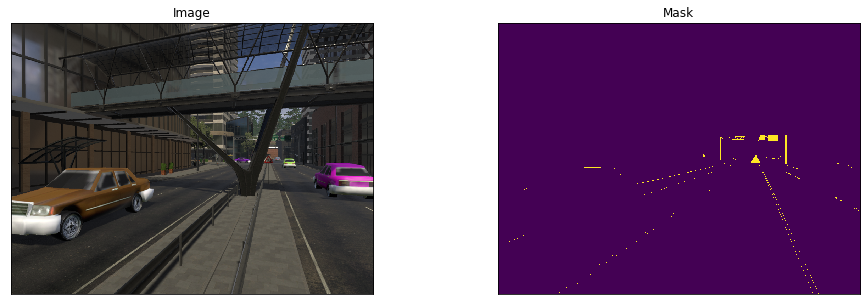

traffic_light


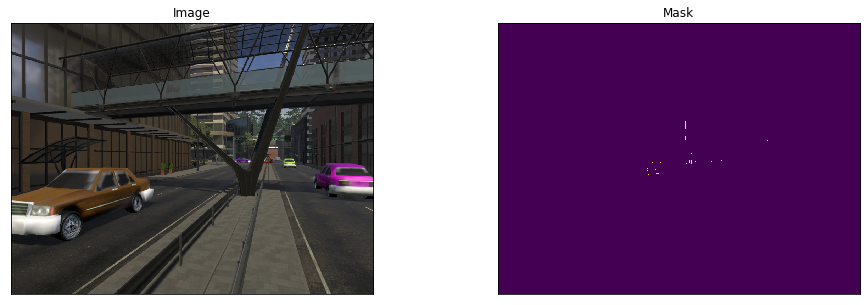

bench


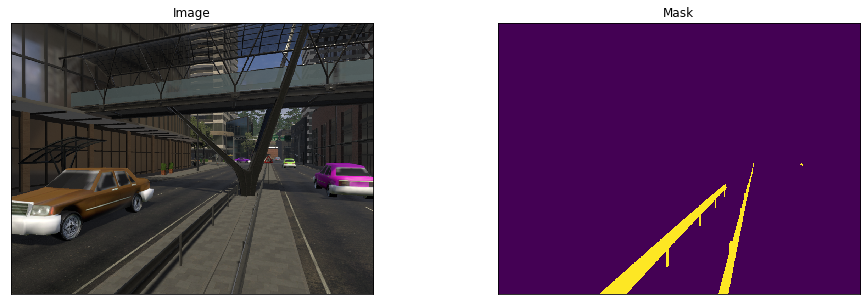

pole


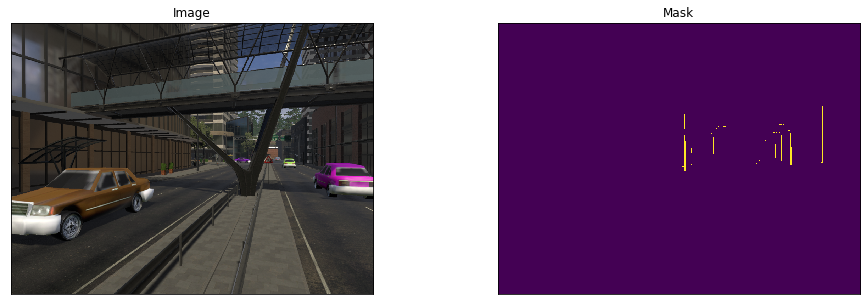

fence


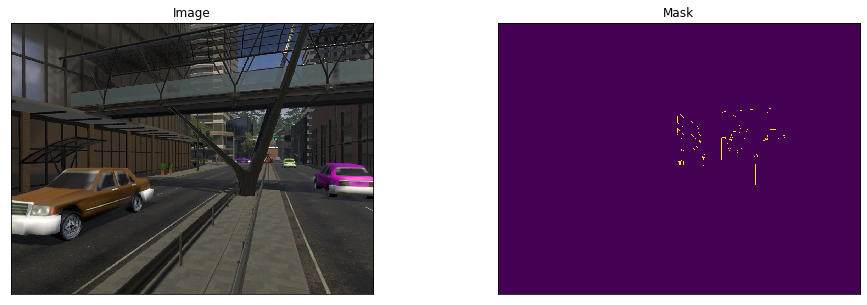

vegetation


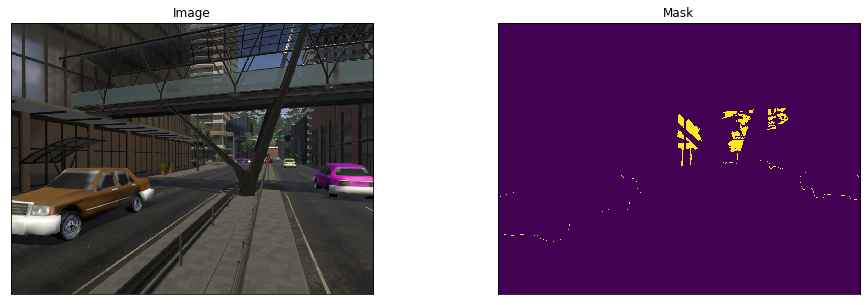

bicycle


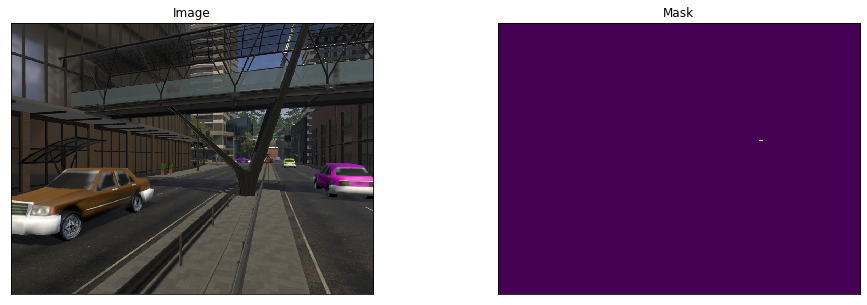

car


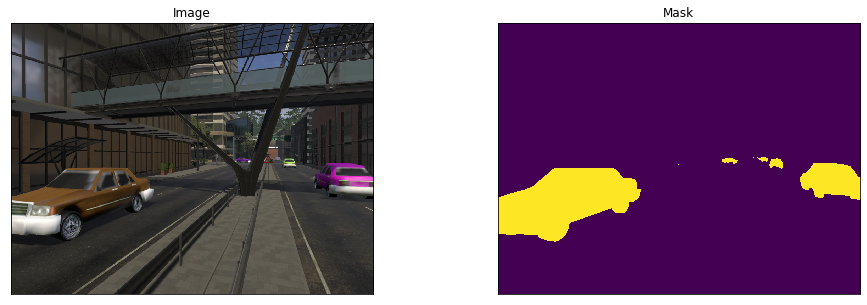

motorcycle


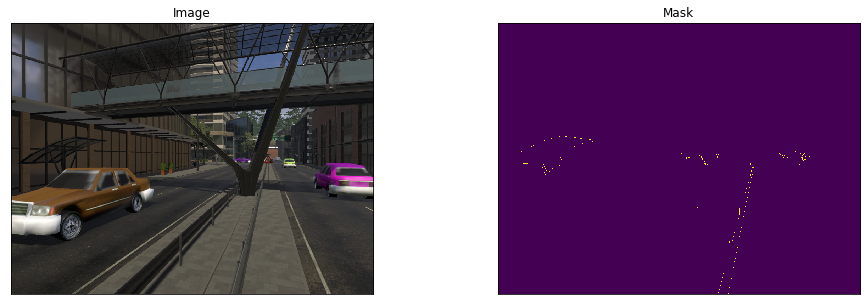

bus


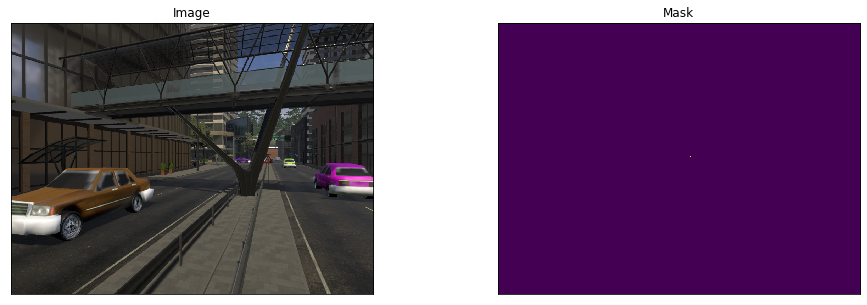

truck


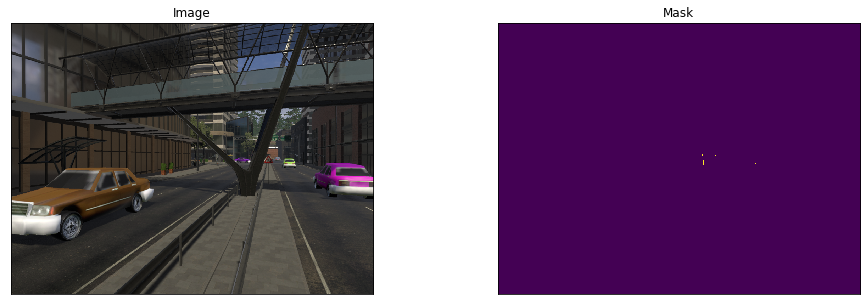

wall


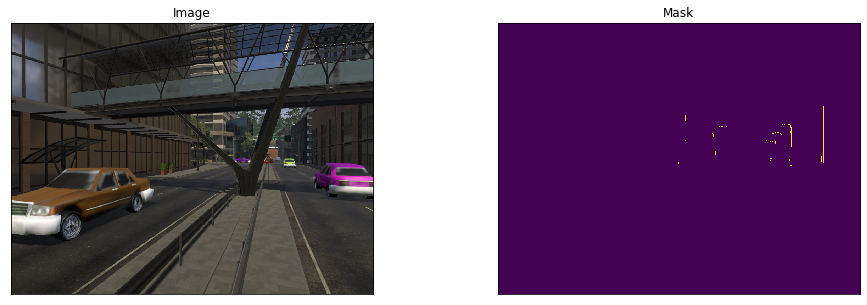

IndexError: list index out of range

<Figure size 1152x360 with 0 Axes>

In [6]:
classes = \
['person', 'rider_other', 'bicycle', 'building', 'sidewalk_pavement', 'road', 'wall', 'fence', 'pole',
 'traffic_light', 'traffic_sign', 'vegetation', 'terrain', 'potted_plant', 'lane_marking',
 'motorcycle', 'car', 'truck', 'bus', 'train', 'pedestrian_crossing', 'fire_hydrant', 'bench', 'void']

dataset = MSegDataset(x_valid_dir, y_valid_dir, classes)

image, mask = dataset[8]

for i in np.unique(mask):
    plt.figure(figsize=(16,5))
    print(dataset.MSEG_CLASSES[i])
    visualize(
        image=image, 
        mask=mask==i,
    )
    plt.show()

In [7]:
np.unique(mask)

array([ 35,  64,  98, 100, 102, 126, 135, 136, 139, 143, 144, 174, 175,
       176, 178, 180, 182, 191, 194], dtype=uint8)